## Load Data

Image, Semantic Mask, LiDAR pointcloud and TF transformantions

In [1]:
from pathlib import Path
import os

import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
IMG_FILENAMES_PATH='/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/filenames.txt'
IMG_DIR_PATH = '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/'
IMG_TS_PATH='/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/timestamps.txt'

CLOUD_FILENAMES_PATH='/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/velodyne_points/filenames.txt'
CLOUD_DIR_PATH = '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/velodyne_points/clouds/'
CLOUD_TS_PATH='/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/velodyne_points/timestamps.txt'
SEMMASK_DIR_PATH='/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/anno_demo'
TF_PATH=None

CAM_CONFIG_PATH='/home/kowalski/data/MIPT_campus/cam.yml'


In [3]:
import json

In [4]:
with open('/home/kowalski/data/MIPT_campus/anno_config.json', 'r') as f:
    seg_config = json.load(f)

STUFF_CLASSES = seg_config['stuff_classes']
STUFF_COLORS = seg_config['stuff_colors']

PLOTLY_COLORSCALE=[ f'rgb({r},{g},{b})' for r,g,b in STUFF_COLORS]

In [5]:
PLOTLY_COLORSCALE[:10]

['rgb(125,125,125)',
 'rgb(165,42,42)',
 'rgb(0,192,0)',
 'rgb(196,196,196)',
 'rgb(255,119,0)',
 'rgb(180,165,180)',
 'rgb(90,120,150)',
 'rgb(102,102,156)',
 'rgb(128,64,255)',
 'rgb(140,140,200)']

In [11]:
import glob

In [16]:
img_list = []
img_ts = []
clouds_list = []
clouds_ts = []
anno_list = []

img_list = sorted(glob.glob(IMG_DIR_PATH + "/*.png"))

with open(IMG_TS_PATH, 'r') as f:
    img_ts = np.asarray(sorted([float(filename[:-1]) for filename in f.readlines()]))


clouds_list = sorted(glob.glob(CLOUD_DIR_PATH + "/*.bin"))

with open(CLOUD_TS_PATH, 'r') as f:
    clouds_ts = np.asarray(sorted([float(filename[:-1]) for filename in f.readlines()]))

anno_list = sorted(os.listdir(SEMMASK_DIR_PATH))

# assert len(img_list)==len(clouds_list), \
#     f"The number of images doesn't match the number of pointclouds! ({len(img_list)} != {len(clouds_list)})"
# assert len(img_list)==len(anno_list), \
#     f"The number of images doesn't match the number of annotations! ({len(img_list)} != {len(anno_list)})"



In [17]:
img_list

['/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000006.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000017.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000038.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000050.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000062.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000073.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_image_rect_color_compressed/images/00000096.png',
 '/home/kowalski/data/MIPT_campus/unpacked_2023-02-21-07-28-58-day/zed_node_left_im

In [18]:
def imshow(img, mask=False):
    if type(img) is str:
        img =  cv2.imread(img)
    elif type(img) is int:
         img = cv2.imread(os.path.join(IMG_DIR_PATH, img_list[img]), cv2.IMREAD_UNCHANGED)
    
    plt.figure(figsize=[10, 10])
    if not mask:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)

In [19]:
import plotly.graph_objects as go
import numpy as np

In [20]:
def cloudshow(cloud, colors=None):
    ll = np.array([-40, -40, -2])  # lower-left
    ur = np.array([40, 40, 15])  # upper-right
    colored = not colors is None

    if not colored:
        colors = cloud[:,2]
        colorscale = 'Viridis'
        label=None
    else:
        colorscale = PLOTLY_COLORSCALE

    in_range_idx = np.all(np.logical_and(ll <= cloud, cloud <= ur), axis=1)

    
    cloud_clipped = cloud[in_range_idx]
    colors_clipped = colors[in_range_idx]
    # hover_name

    if colored:
        label=[STUFF_CLASSES[idx] for idx in colors_clipped]

    fig = go.Figure(data=[go.Scatter3d(
        x=cloud_clipped[:,0],
        y=cloud_clipped[:,1],
        z=cloud_clipped[:,2],
        mode='markers',
        text=label,
        marker=dict(
            size=2,
            color=colors_clipped,                # set color to an array/list of desired values
            colorscale=colorscale,   # choose a colorscale
            opacity=0.8
        )
    )],)

    # tight layout
    fig.update_layout(scene_aspectmode="data")
    fig.show()

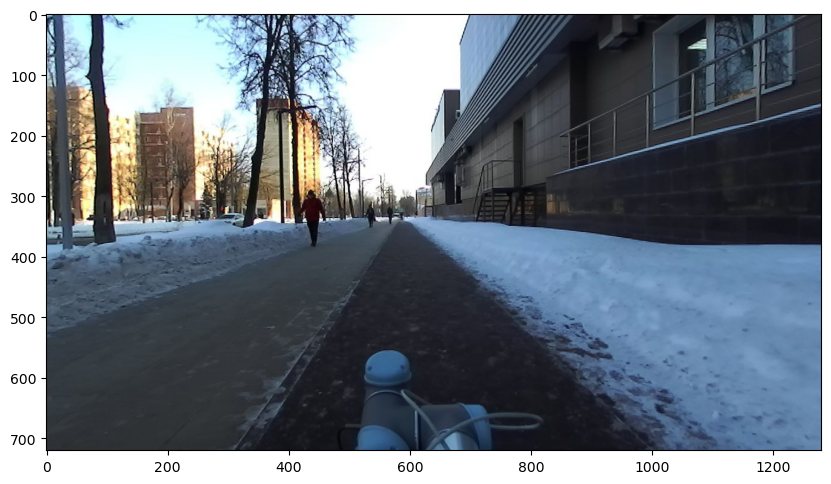

In [99]:
# image
img = cv2.imread(os.path.join(IMG_DIR_PATH, img_list[1200]), cv2.IMREAD_UNCHANGED)

imshow(img)

In [22]:
# pointcloud
veloscan = np.empty((0,4), dtype='float32')

veloscan = np.append(veloscan,\
                     np.asarray((np.fromfile(os.path.join(CLOUD_DIR_PATH, clouds_list[0]), dtype='float32')).reshape(-1, 4)),\
                     axis=0)
veloscan = veloscan[:,:3]


cloudshow(veloscan)

In [23]:
# labels
veloscan.shape

(29184, 3)

In [24]:
import quaternion
from quaternion import as_rotation_matrix

In [25]:
def build_matrix(x, y, z, q):
    M = np.zeros((3,4))
    M[:3, :3] = as_rotation_matrix(q)
    M[:, 3] = x, y, z
    return M


In [26]:
def inv_T(T):
    T = np.vstack((T,np.asarray([0, 0, 0, 1])))
    T_inv = np.linalg.inv(T)
    return T_inv[:3]

In [27]:
# TFse3quat_to_matrix
# lidar2left_cam_q = np.quaternion(-0.510,-0.498, 0.498, -0.495) # w, x, y, z
# lidar2left_cam_t = np.asarray([0.061, 0.049, -0.131])

lidar2left_cam_q = np.quaternion(-0.5098432024259881,-0.497602232228181, 0.49791462150659926, -0.4945027372133386) # w, x, y, z
lidar2left_cam_t = np.asarray([0.04632155672047202, -0.1327858803524132, -0.06092748914769486])

lidar2left_cam_T = build_matrix(*lidar2left_cam_t, lidar2left_cam_q)
left_cam2lidar_T = inv_T(lidar2left_cam_T)

In [28]:
left_cam2lidar_T

array([[ 0.01509615,  0.00871086,  0.9998481 ,  0.06137564],
       [-0.99976457,  0.01571812,  0.01495794,  0.04930915],
       [-0.01558544, -0.99983852,  0.0089461 , -0.13149743]])

In [29]:
lidar2left_cam_T

array([[ 0.01509615, -0.99976457, -0.01558544,  0.04632156],
       [ 0.00871086,  0.01571812, -0.99983852, -0.13278588],
       [ 0.9998481 ,  0.01495794,  0.0089461 , -0.06092749]])

In [30]:
import yaml

In [31]:
def get_cam_parameters(config_filename):
    
    with open(config_filename, 'r') as f:
        config_cameras = yaml.safe_load(f)
        
    # fx = config_cameras['left']['intrinsics'][0]
    # fy = config_cameras['left']['intrinsics'][1]
    # cx = config_cameras['left']['intrinsics'][2]
    # cy = config_cameras['left']['intrinsics'][3]
    # matrix_intrinsics_left = np.array([[fx, 0, cx],
    #                                    [0, fy, cy],
    #                                    [0,0,1]])
    
    # fx = config_cameras['right']['intrinsics'][0]
    # fy = config_cameras['right']['intrinsics'][1]
    # cx = config_cameras['right']['intrinsics'][2]
    # cy = config_cameras['right']['intrinsics'][3]
    # matrix_intrinsics_right = np.array([[fx, 0, cx],
    #                                    [0, fy, cy],
    #                                    [0,0,1]])
    
    # distortions_left = np.array(config_cameras['left']['distortion_coeffs'])
    
    # distortions_right = np.array(config_cameras['right']['distortion_coeffs'])
    
    left_cam_P = np.array(config_cameras['left_rect']['P'])
    
    # R_left = np.array(config_cameras['left']['T'])[:3,:3]
    # R_left = np.linalg.inv(R_left)
    
    # R_right = np.array(config_cameras['right']['T'])[:3,:3]
    # R_right = np.linalg.inv(R_right)
    
    left_cam_res =  np.array(config_cameras['left_rect']['resolution'])
    
    return left_cam_P, left_cam_res

## Project LiDAR to Cam

In [32]:
from typing import Tuple

In [33]:
def project_points_to_camera(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int], return_points=False
):
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, in_image] # colors
    # cloudshow(points[:3,in_image].T)
    uvw = np.dot(proj_matrix, points[:,in_image])
    # print(f"In points[:, in_image] len {uvw.shape}")
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1])
    return uv[:, in_image].astype(int), depths[in_image]


def depths_to_colors(depths: np.ndarray, max_depth: int = 100, cmap: str = "hsv") -> np.ndarray:
    depths /= max_depth
    to_colormap = plt.get_cmap(cmap)
    rgba_values = to_colormap(depths, bytes=True)
    return rgba_values[:, :3].astype(int)

In [34]:
def project_points_to_camera_2(
    points: np.ndarray, proj_matrix: np.ndarray, cam_res: Tuple[int, int], return_mask=False
):
    if points.shape[0] == 3:
        points = np.vstack((points, np.ones((1, points.shape[1]))))
    
    if len(points.shape) != 2 or points.shape[0] != 4:
        raise ValueError(
            f"Wrong shape of points array: {points.shape}; expected: (4, n), where n - number of points."
        )
    if proj_matrix.shape != (3, 4):
        raise ValueError(f"Wrong proj_matrix shape: {proj_matrix}; expected: (3, 4).")
    in_image = points[2, :] > 0
    depths = points[2, :] # colors
    # cloudshow(points[:3,in_image].T)
    uvw = np.dot(proj_matrix, points)
    # print(f"In points[:, in_image] len {uvw.shape}")
    uv = uvw[:2, :]
    w = uvw[2, :]
    uv[0, :] /= w
    uv[1, :] /= w
    in_image = (uv[0, :] >= 0) * (uv[0, :] < cam_res[0]) * (uv[1, :] >= 0) * (uv[1, :] < cam_res[1]) * in_image
    if return_mask:
        return uv[:, in_image].astype(int), depths[in_image], in_image
    return uv[:, in_image].astype(int), depths[in_image]

In [36]:
# tf_lidar2cam = tf.transformations.quaternion_matrix(rot)
# tf_lidar2cam[:3, 3] = trans

proj_cam, cam_res = get_cam_parameters('/home/kowalski/data/MIPT_campus/calib/zed_calib.yml')
# proj_cam = np.array(camera_info.P).reshape((3, 4))
# cam_res = (camera_info.width, camera_info.height)

# im_ts = compressed_image_msg.header.stamp.to_nsec()
# pc_ts = lidar_msg.header.stamp.to_nsec()
# ts_diff = np.abs(im_ts - pc_ts) / 1000000
# rospy.logdebug(f"ts_diff = {ts_diff:.3f} ms")
proj_img = img.copy()

lidar_points = veloscan.T
if lidar_points.shape[0] == 3:
    lidar_points = np.vstack((lidar_points, np.ones((1, lidar_points.shape[1]))))

lidar_points = lidar2left_cam_T @ lidar_points

uv, depth = project_points_to_camera_2(lidar_points, proj_cam, cam_res)
rgb_distances = depths_to_colors(depth, max_depth=100)
for point, d in zip(uv.T, rgb_distances):
    c = (int(d[0]), int(d[1]), int(d[2]))
    proj_img = cv2.circle(proj_img, point, radius=2, color=c, thickness=cv2.FILLED)

In [37]:
proj_cam

array([[683.156677,   0.      , 615.100403,   0.      ],
       [  0.      , 683.156677, 345.332916,   0.      ],
       [  0.      ,   0.      ,   1.      ,   0.      ]])

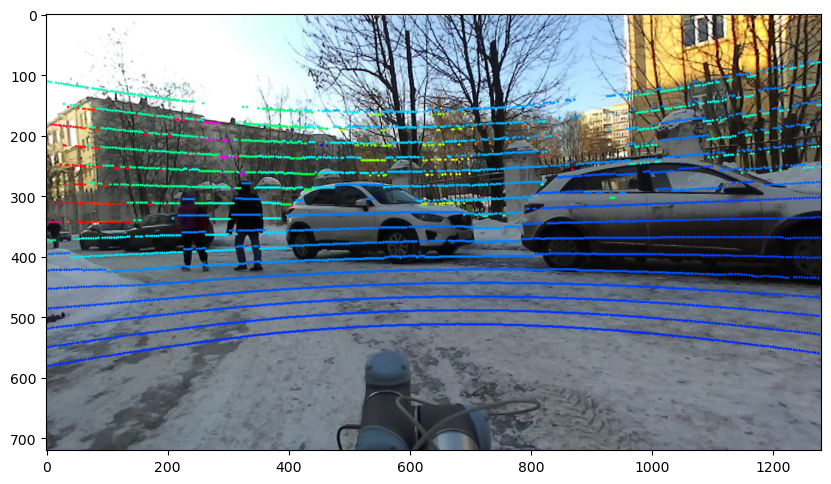

In [38]:
imshow(proj_img)

## Draw Semantic masks

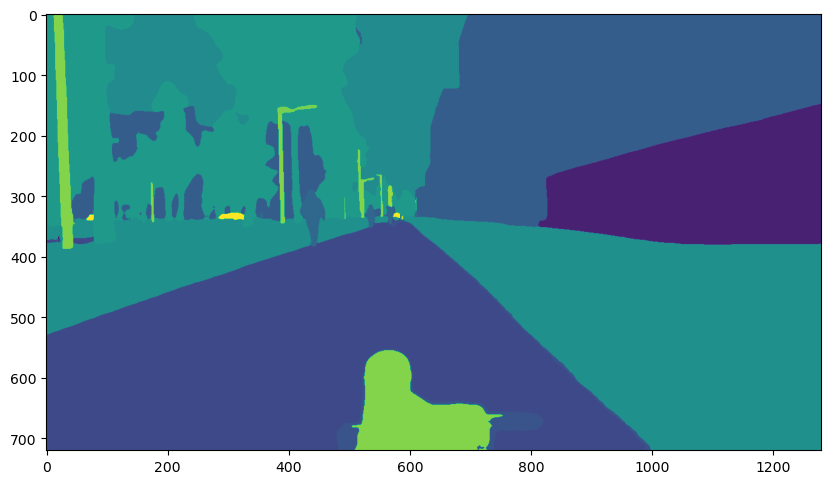

In [100]:
# mask
mask = cv2.imread(os.path.join(SEMMASK_DIR_PATH, anno_list[1200]), cv2.IMREAD_UNCHANGED)

imshow(mask, mask=True)

In [51]:
ret, thresh = cv2.threshold(mask,30,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [57]:
np.unique(mask, return_counts=True)

(array([ 3,  6, 13, 15, 17, 19, 27, 28, 30, 35, 42, 44, 45, 49, 51, 52, 55],
       dtype=uint8),
 array([ 24853,  15635,  95344,     39,  17306,  11706,  50978, 298789,
        261822,     31,      4,    157,   1346,    387,      1,  25192,
        118010]))

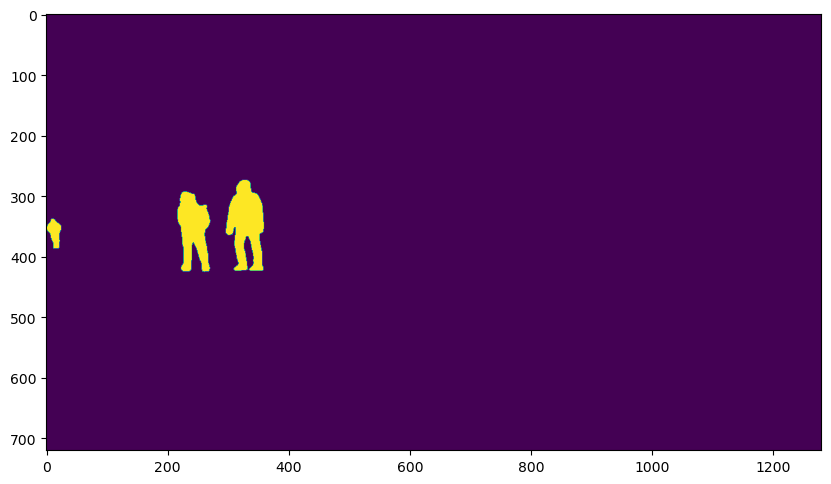

In [61]:
imshow(mask==19, mask=True)

In [63]:
ccw_output = cv2.connectedComponentsWithStats(np.asarray(mask==19, dtype=np.uint8), connectivity=8, ltype=cv2.CV_32S)

In [66]:
ccw_output[3]

array([[644.18815928, 359.59527813],
       [330.53567969, 347.86470778],
       [242.99206018, 356.31989135],
       [ 13.72038567, 360.32093664]])

In [75]:
human_mask = np.asarray(mask==19, dtype=np.uint8)

In [68]:
human_mask.shape

(720, 1280)

In [77]:
human_mask_copy = human_mask.copy()

for w, h in ccw_output[3]:
    c = (255, 0, 0)
    point = (int(w), int(h))
    human_mask_copy = cv2.circle(human_mask_copy, point, radius=5, color=c, thickness=cv2.FILLED)


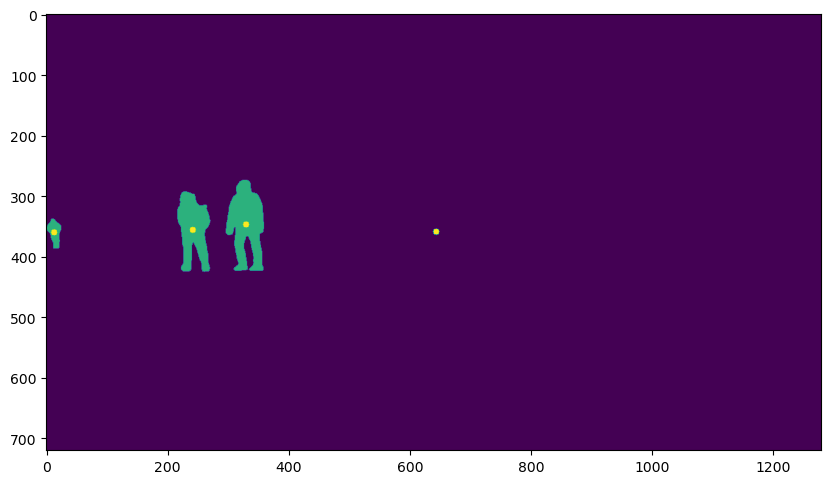

In [83]:
imshow(human_mask + 100* human_mask_copy, mask=True)

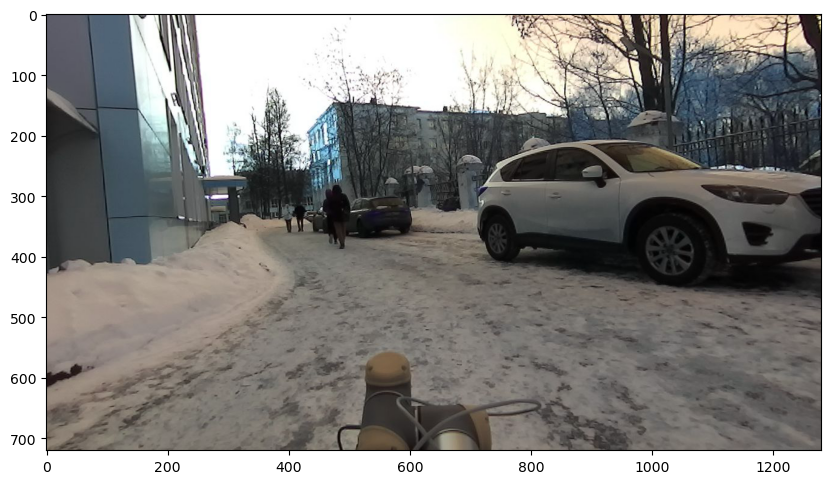

In [42]:
imshow(ccw_output[0], mask=True)

In [ ]:
src = cv2.imread('/directorypath/image.bmp')
# Threshold it so it becomes binary
ret, thresh = cv2.threshold(src,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# You need to choose 4 or 8 for connectivity type
connectivity = 4  
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

In [116]:
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import pycocotools.mask as mask_util
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [117]:
class VisImage:
    def __init__(self, img, scale=1.0):
        """
        Args:
            img (ndarray): an RGB image of shape (H, W, 3) in range [0, 255].
            scale (float): scale the input image
        """
        self.img = img
        self.scale = scale
        self.width, self.height = img.shape[1], img.shape[0]
        self._setup_figure(img)

    def _setup_figure(self, img):
        """
        Args:
            Same as in :meth:`__init__()`.
        Returns:
            fig (matplotlib.pyplot.figure): top level container for all the image plot elements.
            ax (matplotlib.pyplot.Axes): contains figure elements and sets the coordinate system.
        """
        fig = mplfigure.Figure(frameon=False)
        self.dpi = fig.get_dpi()
        # add a small 1e-2 to avoid precision lost due to matplotlib's truncation
        # (https://github.com/matplotlib/matplotlib/issues/15363)
        fig.set_size_inches(
            (self.width * self.scale + 1e-2) / self.dpi,
            (self.height * self.scale + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(fig)
        # self.canvas = mpl.backends.backend_cairo.FigureCanvasCairo(fig)
        ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax.axis("off")
        self.fig = fig
        self.ax = ax
        self.reset_image(img)

    def reset_image(self, img):
        """
        Args:
            img: same as in __init__
        """
        img = img.astype("uint8")
        self.ax.imshow(img, extent=(0, self.width, self.height, 0), interpolation="nearest")

    def save(self, filepath):
        """
        Args:
            filepath (str): a string that contains the absolute path, including the file name, where
                the visualized image will be saved.
        """
        self.fig.savefig(filepath)

    def get_image(self):
        """
        Returns:
            ndarray:
                the visualized image of shape (H, W, 3) (RGB) in uint8 type.
                The shape is scaled w.r.t the input image using the given `scale` argument.
        """
        canvas = self.canvas
        s, (width, height) = canvas.print_to_buffer()
        # buf = io.BytesIO()  # works for cairo backend
        # canvas.print_rgba(buf)
        # width, height = self.width, self.height
        # s = buf.getvalue()

        buffer = np.frombuffer(s, dtype="uint8")

        img_rgba = buffer.reshape(height, width, 4)
        rgb, alpha = np.split(img_rgba, [3], axis=2)
        return rgb.astype("uint8")

In [118]:
def draw_binary_mask(binary_mask, color=None, *, res_img, alpha=0.5):
        """
        Args:
            binary_mask (ndarray): numpy array of shape (H, W), where H is the image height and
                W is the image width. Each value in the array is either a 0 or 1 value of uint8
                type.
            color: color of the mask. Refer to `matplotlib.colors` for a full list of
                formats that are accepted. If None, will pick a random color.
            edge_color: color of the polygon edges. Refer to `matplotlib.colors` for a
                full list of formats that are accepted.
            text (str): if None, will be drawn on the object
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            area_threshold (float): a connected component smaller than this area will not be shown.
        Returns:
            output (VisImage): image object with mask drawn.
        """
        color = mplc.to_rgb(color)

        binary_mask = binary_mask.astype("uint8")  # opencv needs uint8
        # mask = GenericMask(binary_mask, self.output.height, self.output.width)
        shape2d = (binary_mask.shape[0], binary_mask.shape[1])

        rgba = np.zeros(shape2d + (4,), dtype="float32")
        rgba[:, :, :3] = color
        rgba[:, :, 3] = (binary_mask == 1).astype("float32") * alpha
        res_img.ax.imshow(rgba, extent=(0, res_img.width, res_img.height, 0))
        
        return res_img

In [119]:
def show_mask(img, mask, alpha=0.5, show=True):
    res_img = VisImage(img)

    labels, areas = np.unique(mask, return_counts=True)
    sorted_idxs = np.argsort(-areas).tolist()
    labels = labels[sorted_idxs]
    for label in filter(lambda l: l < len(STUFF_CLASSES), labels):
        try:
            mask_color = [x / 255 for x in STUFF_COLORS[label]]
        except (AttributeError, IndexError):
            mask_color = None

        binary_mask = (mask == label).astype(np.uint8)
        res_img = draw_binary_mask(
            binary_mask,
            color=mask_color,
            res_img=res_img,
            alpha=alpha,
        )
    
    if show:
        plt.figure(figsize=[10, 10])
        plt.imshow(res_img.get_image())

    return res_img

In [120]:
np.unique(mask)

array([ 1,  6, 13, 15, 17, 19, 27, 28, 30, 35, 44, 45, 47, 49, 51, 55],
      dtype=uint8)

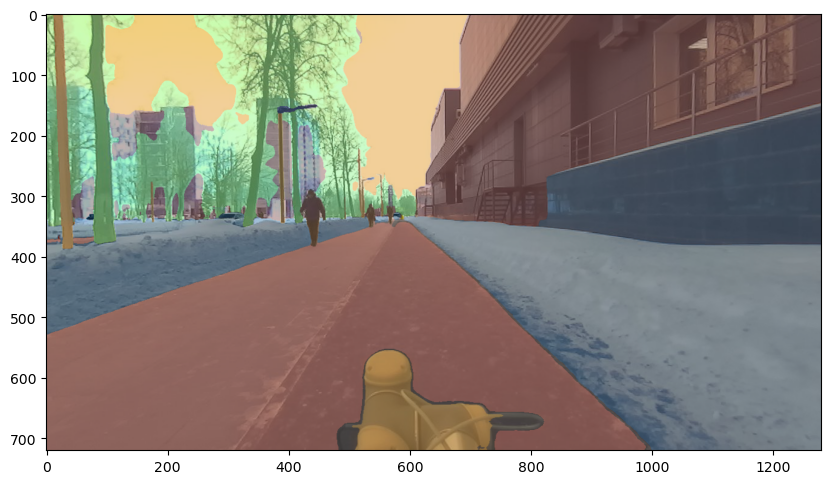

In [121]:
show_mask(img, mask)

In [114]:
show_mask(img, mask, alpha=1)

NameError: name 'mplfigure' is not defined

In [115]:
colored_mask = show_mask(img, mask, alpha=1, show=False).get_image()

imshow(colored_mask, mask=True)

NameError: name 'mplfigure' is not defined

In [ ]:
colored_mask.dtype == np.uint8

## Color lidar pointcloud by mask (backprojection)

In [35]:
def get_colors_by_mask(mask):
    # rgb_distances = depths_to_colors(depth, max_depth=100)
    colors = []
    for img_point in uv.T:
        colors.append(mask[img_point[1], img_point[0]])
    
    return np.asarray(colors)

In [36]:
uv, depth, in_image = project_points_to_camera_2(lidar_points, proj_cam, cam_res, return_mask=True)

In [37]:
len(in_image) == len(veloscan)

True

In [38]:
veloscan_colors = get_colors_by_mask(colored_mask)

In [39]:
veloscan_labels = get_colors_by_mask(mask)

In [40]:
cloudshow(veloscan[in_image], colors=veloscan_labels)